In [15]:
import gc
import lightgbm as lgb  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import polars as pl  # type: ignore
import warnings

from catboost import CatBoostClassifier, Pool  # type: ignore
from glob import glob
from IPython.display import display  # type: ignore
from pathlib import Path
from sklearn.base import BaseEstimator, ClassifierMixin  # type: ignore
from sklearn.metrics import roc_auc_score  # type: ignore
from sklearn.model_selection import StratifiedGroupKFold  # type: ignore
from typing import Any

warnings.filterwarnings("ignore")

ROOT = Path("/kaggle/input/home-credit-credit-risk-model-stability") # location of train/test file, relevant data can be found on kaggle
TRAIN_DIR = ROOT / "parquet_files" / "train"
TEST_DIR = ROOT / "parquet_files" / "test"

# Preliminary function setup

In [16]:
class Utility:
    @staticmethod
    def reduce_memory_usage(df: pl.DataFrame, name) -> pl.DataFrame:
        """
        Reduces memory usage of a DataFrame by converting column types.

        Args:
        - df (pl.DataFrame): DataFrame to optimize.
        - name (str): Name of the DataFrame.

        Returns:
        - pl.DataFrame: Optimized DataFrame.
        """
        print(
            f"Memory usage of dataframe \"{name}\" is {round(df.estimated_size('mb'), 4)} MB."
        )

        int_types = [
            pl.Int8,
            pl.Int16,
            pl.Int32,
            pl.Int64,
            pl.UInt8,
            pl.UInt16,
            pl.UInt32,
            pl.UInt64,
        ]
        float_types = [pl.Float32, pl.Float64]

        for col in df.columns:
            col_type = df[col].dtype
            if col_type in int_types + float_types:
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min is not None and c_max is not None:
                    if col_type in int_types:
                        if c_min >= 0:
                            if (
                                c_min >= np.iinfo(np.uint8).min
                                and c_max <= np.iinfo(np.uint8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt8))
                            elif (
                                c_min >= np.iinfo(np.uint16).min
                                and c_max <= np.iinfo(np.uint16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt16))
                            elif (
                                c_min >= np.iinfo(np.uint32).min
                                and c_max <= np.iinfo(np.uint32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt32))
                            elif (
                                c_min >= np.iinfo(np.uint64).min
                                and c_max <= np.iinfo(np.uint64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt64))
                        else:
                            if (
                                c_min >= np.iinfo(np.int8).min
                                and c_max <= np.iinfo(np.int8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int8))
                            elif (
                                c_min >= np.iinfo(np.int16).min
                                and c_max <= np.iinfo(np.int16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int16))
                            elif (
                                c_min >= np.iinfo(np.int32).min
                                and c_max <= np.iinfo(np.int32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int32))
                            elif (
                                c_min >= np.iinfo(np.int64).min
                                and c_max <= np.iinfo(np.int64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int64))
                    elif col_type in float_types:
                        if (
                            c_min > np.finfo(np.float32).min
                            and c_max < np.finfo(np.float32).max
                        ):
                            df = df.with_columns(df[col].cast(pl.Float32))

        print(
            f"Memory usage of dataframe \"{name}\" became {round(df.estimated_size('mb'), 4)} MB."
        )

        return df

    @staticmethod
    def to_pandas(df: pl.DataFrame, cat_cols: list[str] = None) -> (pd.DataFrame, list[str]):  # type: ignore
        """
        Converts a Polars DataFrame to a Pandas DataFrame.

        Args:
        - df (pl.DataFrame): Polars DataFrame to convert.
        - cat_cols (list[str]): List of categorical columns. Default is None.

        Returns:
        - (pd.DataFrame, list[str]): Tuple containing the converted Pandas DataFrame and categorical columns.
        """
        df: pd.DataFrame = df.to_pandas()

        if cat_cols is None:
            cat_cols = list(df.select_dtypes("object").columns) # Treat categorical variables as object columns and convert them to strings to avoid mixed types and null-related issues. 

        df[cat_cols] = df[cat_cols].astype("str")

        return df, cat_cols

The Utility class is a stateless helper class designed to support data preprocessing.
1. *reduce_memory_usage* iterates over numeric columns in a DataFrame. Integer and floating-point columns are cast to the smallest compatible data types (e.g., int64 → int8 / int16, float64 → float32)
2. *to_pandas* converts a Polars DataFrame into a Pandas DataFrame and automatically detects categorical features by selecting columns with the object dtype.

In [17]:
class Aggregator:
    @staticmethod
    def max_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating maximum values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for maximum values.
        """
        cols: list[str] = [
            col
            for col in df.columns
            if (col[-1] in ("P", "M", "A", "D", "T", "L")) or ("num_group" in col)
        ]

        expr_max: list[pl.Series] = [
            pl.col(col).max().alias(f"max_{col}") for col in cols
        ]

        return expr_max

    @staticmethod
    def mean_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating mean values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for mean values.
        """
        cols: list[str] = [col for col in df.columns if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).mean().alias(f"mean_{col}") for col in cols
        ]

        return expr_mean

    @staticmethod
    def var_expr(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Generates expressions for calculating variance for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for variance.
        """
        cols: list[str] = [col for col in df.columns if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).var().alias(f"var_{col}") for col in cols
        ]

        return expr_mean

    @staticmethod
    def get_exprs(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Combines expressions for maximum, mean, and variance calculations.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of combined expressions.
        """
        exprs = (
            Aggregator.max_expr(df) + Aggregator.mean_expr(df) + Aggregator.var_expr(df)
        )

        return exprs

Because features at depth 1 and 2 cannot be directly consumed by downstream models, they must be transformed through aggregation. In this step, we construct aggregated statistics such as max, mean, and variance to summarize the underlying behavior. This design is extensible, allowing additional aggregation methods to be easily incorporated in the future if needed.

In [18]:
class SchemaGen:
    @staticmethod
    def change_dtypes(df: pl.LazyFrame) -> pl.LazyFrame:
        """
        Changes the data types of columns in the DataFrame.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - pl.LazyFrame: LazyFrame with modified data types.
        """
        for col in df.columns:
            if col == "case_id":
                df = df.with_columns(pl.col(col).cast(pl.UInt32).alias(col))
            elif col in ["WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.UInt16).alias(col))
            elif col == "date_decision" or col[-1] == "D":
                df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
            elif col[-1] in ["P", "A"]:
                df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
        return df

    @staticmethod
    def scan_files(glob_path: str, depth: int = None):
        chunks = []
        for path in glob(str(glob_path)):
            df = pl.read_parquet(path, low_memory=True, rechunk=True)
            df = df.pipe(SchemaGen.change_dtypes)
            if depth in [1, 2]:
                df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
            chunks.append(df)
        df = pl.concat(chunks, how="vertical_relaxed")
        del chunks
        gc.collect()
        df = df.unique(subset=["case_id"])
        return df

    @staticmethod
    def join_dataframes(df_base, depth_0, depth_1, depth_2):
        for i, df in enumerate(depth_0 + depth_1 + depth_2):
            df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        return df_base


I initially wrote this block to handle loading data from depth 0, 1, and 2 tables.
As a result, applying an additional change_dtypes step here may be slightly redundant, since a similar conversion to reduce memory already exists elsewhere in the pipeline.
This can be optimized in a future refactor.

In [19]:
def filter_cols(df: pl.DataFrame) -> pl.DataFrame:
    """
    Filters columns in the DataFrame based on null percentage and unique values for string columns.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with filtered columns.
    """
    for col in df.columns:
        if col not in ["case_id", "year", "month", "week_num", "target"]:
            null_pct = df[col].is_null().mean()

            if null_pct > 0.95:
                df = df.drop(col) # drop columns if 95% percent null

    for col in df.columns:
        if (col not in ["case_id", "year", "month", "week_num", "target"]) & (
            df[col].dtype == pl.String
        ):
            freq = df[col].n_unique()

            if (freq > 200) | (freq == 1): # drop columns with no variance (single unique value) or extremely high cardinality
                df = df.drop(col)

    return df


def transform_cols(df: pl.DataFrame) -> pl.DataFrame:
    """
    Transforms columns in the DataFrame according to predefined rules.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with transformed columns.
    """
    if "riskassesment_302T" in df.columns:
        if df["riskassesment_302T"].dtype == pl.Null:
            df = df.with_columns(
                [
                    pl.Series(
                        "riskassesment_302T_rng", df["riskassesment_302T"], pl.UInt8
                    ),
                    pl.Series(
                        "riskassesment_302T_mean", df["riskassesment_302T"], pl.UInt8
                    ),
                ]
            )
        else:
            pct_low: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[0].replace("%", ""))
                .cast(pl.UInt8)
            )
            pct_high: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[1].replace("%", ""))
                .cast(pl.UInt8)
            )

            diff: pl.Series = pct_high - pct_low
            avg: pl.Series = ((pct_low + pct_high) / 2).cast(pl.Float32)

            del pct_high, pct_low
            gc.collect()

            df = df.with_columns(
                [
                    diff.alias("riskassesment_302T_rng"),
                    avg.alias("riskassesment_302T_mean"),
                ]
            )

        df.drop("riskassesment_302T")

    return df


def handle_dates(df: pl.DataFrame) -> pl.DataFrame:
    """
    Handles date columns in the DataFrame.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with transformed date columns.
    """
    for col in df.columns:
        if col.endswith("D"):
            df = df.with_columns(pl.col(col) - pl.col("date_decision"))
            df = df.with_columns(pl.col(col).dt.total_days().cast(pl.Int32))

    df = df.rename(
        {
            "MONTH": "month",
            "WEEK_NUM": "week_num"
        }
    )
            
    df = df.with_columns(
        [
            pl.col("date_decision").dt.year().alias("year").cast(pl.Int16),
            pl.col("date_decision").dt.day().alias("day").cast(pl.UInt8),
        ]
    )

    return df.drop("date_decision")

*riskassesment_302T* represents the estimated probability that a client will default on their credit obligation within the next year. This variable is therefore highly informative for default prediction. However, it is provided as a range rather than a point estimate, so we derive two numerical features: the mean of the range and its width.

And in terms of date feature engineering, we adopt a relatively conservative strategy. To simplify the model and improve its generalization ability, all date-related features are transformed into relative time differences with respect to the loan decision date (date_decision).

# Read train and test data

In [20]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        SchemaGen.scan_files(TRAIN_DIR / "train_static_cb_0.parquet"),
        SchemaGen.scan_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        SchemaGen.scan_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_other_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_person_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_deposit_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ],
}

df_train: pl.DataFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(filter_cols)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .pipe(Utility.reduce_memory_usage, "df_train")
)

del data_store
gc.collect()

print(f"Train data shape: {df_train.shape}")
display(df_train.head(10))

Memory usage of dataframe "df_train" is 4711.2195 MB.
Memory usage of dataframe "df_train" became 2665.6302 MB.
Train data shape: (1526659, 472)


case_id,month,week_num,target,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,…,mean_mainoccupationinc_384A,max_amount_416A,max_num_group1_10,max_openingdate_313D,mean_amount_416A,mean_openingdate_313D,max_num_group1_11,max_openingdate_857D,mean_openingdate_857D,max_collater_typofvalofguarant_298M,max_collater_typofvalofguarant_407M,max_collater_valueofguarantee_1124L,max_collater_valueofguarantee_876L,max_collaterals_typeofguarante_359M,max_collaterals_typeofguarante_669M,max_num_group1_12,max_num_group2,max_pmts_dpd_1073P,max_pmts_dpd_303P,max_pmts_month_158T,max_pmts_month_706T,max_pmts_overdue_1140A,max_pmts_overdue_1152A,max_pmts_year_1139T,max_pmts_year_507T,max_subjectroles_name_541M,max_subjectroles_name_838M,mean_pmts_dpd_1073P,mean_pmts_dpd_303P,mean_pmts_overdue_1140A,mean_pmts_overdue_1152A,var_pmts_dpd_1073P,var_pmts_dpd_303P,var_pmts_overdue_1140A,var_pmts_overdue_1152A,year,day
u32,u32,u8,u8,i16,u8,i16,f32,i32,f32,f32,f32,f32,f32,str,str,str,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,str,i8,u8,i8,f32,f32,f32,f32,f32,…,f32,f32,u8,i16,f32,i16,u8,i16,i16,str,str,f32,f32,str,str,u16,u8,f32,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,f32,u16,u8
2687555,202007,79,0,null,null,null,222174.90625,-24937,1.0,1.0,0.0,5.0,1.0,"""2fc785b2""","""6b2ae0fa""","""a55475b1""",1.0,5.0,"""3439d993""","""a55475b1""",5.0,null,null,null,null,null,null,null,null,null,14,2.0,5.0,0.0,280599.4375,7794.600098,…,47600.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,127100.0,"""c7a5ad39""","""c7a5ad39""",21,35,0.0,1.0,12.0,12.0,0.0,5513.333984,2021.0,2021.0,"""ab3c25cf""","""ab3c25cf""",0.0,0.003831,0.0,21.123884,0.0,0.003831,0.0,116463.03125,2020,10
607382,201901,1,0,null,null,-13768,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,6.0,3394.199951,null,14,null,null,null,null,null,null,3957.400146,…,20000.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2019,10
908064,201912,50,0,null,null,null,null,-15817,1.0,1.0,1.0,3.0,1.0,"""a55475b1""","""717ddd49""","""a55475b1""",3.0,1.0,"""3439d993""","""a55475b1""",3.0,null,null,null,null,null,null,"""DEDUCTION_6""",null,14,null,2.0,2.0,null,null,1476.200073,…,30000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,0.0,"""a55475b1""","""c7a5ad39""",4,35,0.0,3.0,12.0,12.0,0.0,1143.800049,2020.0,2020.0,"""ab3c25cf""","""ab3c25cf""",0.0,0.040541,0.0,15.456757,0.0,0.121622,0.0,17679.4375,2019,22
1329213,201904,13,0,-2294,null,-23499,null,-23499,1.0,2.0,1.0,10.0,1.0,"""a55475b1""","""6b2ae0fa""","""a55475b1""",1.0,8.0,"""b6cabe76""","""a55475b1""",10.0,13743.0,null,null,5.0,null,null,null,14,null,null,4.0,9.0,0.0,219892.203125,2216.600098,…,50000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",3,35,0.0,null,12.0,null,0.0,null,2020.0,null,"""a55475b1""","""ab3c25cf""",0.0,null,0.0,null,0.0,null,0.0,null,2019,3
1618334,201911,44,0,null,null,null,null,-19639,1.0,1.0,0.0,3.0,0.0,"""a55475b1""","""39a0853f""","""a55475b1""",0.0,2.0,"""3439d993""","""a55475b1""",3.0,null,null,null,null,null,null,"""DEDUCTION_6""",null,14,null,2.0,3.0,0.0,0.0,1552.400024,…,26000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",4.90

In [21]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        SchemaGen.scan_files(TEST_DIR / "test_static_cb_0.parquet"),
        SchemaGen.scan_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        SchemaGen.scan_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_other_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_person_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_deposit_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ],
}

df_test: pl.DataFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .select([col for col in df_train.columns if col != "target"])
    .pipe(Utility.reduce_memory_usage, "df_test")
)

del data_store
gc.collect()

print(f"Test data shape: {df_test.shape}")

Memory usage of dataframe "df_test" is 0.0298 MB.
Memory usage of dataframe "df_test" became 0.0172 MB.
Test data shape: (10, 471)


In [22]:
df_train, cat_cols = Utility.to_pandas(df_train)
df_test, cat_cols = Utility.to_pandas(df_test, cat_cols)

We did not perform explicit feature selection (e.g., univariate correlation with the target or pairwise collinearity) because tree-based gbdt models are capable of modeling non-linear feature. 

Moreover， given the large sample size, the feature dimensionality does not pose a significant issue for tree-based models.

# model

In [23]:
class VotingModel(BaseEstimator, ClassifierMixin):
    """
    A voting ensemble model that combines predictions from multiple estimators.

    Parameters:
    - estimators (list): List of base estimators.

    Attributes:
    - estimators (list): List of base estimators.

    Methods:
    - fit(X, y=None): Fit the model to the training data.
    - predict_proba(X): Predict class probabilities for samples.
    """

    def __init__(self, estimators: list[BaseEstimator]):
        """
        Initialize the VotingModel with a list of base estimators.

        Args:
        - estimators (list): List of base estimators.
        """
        super().__init__()
        self.estimators = estimators

    def predict_proba(self, X):
        """
        Predict class probabilities for samples.

        Args:
        - X: Input features.

        Returns:
        - numpy.ndarray: Predicted class probabilities.
        """
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

This code block is not used for model training. Instead, it packages the outputs of four pre-trained models and combines them using a soft voting strategy.
For each input sample, all four models independently produce their predicted probability scores. These probability outputs are then aggregated by computing their average across models. The final prediction is obtained based on this averaged probability distribution.

In [24]:
df_subm: pd.DataFrame = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

device: str = "gpu"
est_cnt: int = 6000

DRY_RUN = True if df_subm.shape[0] == 10 else False
if DRY_RUN:
    device = "cpu"
    df_train = df_train.iloc[:50000]
    est_cnt: int = 600 
# becuase the sample test set only has ten rows, we do not use the entire df_train to save our time

print(device)

cpu


In [25]:
X = df_train.drop(columns=["target", "case_id", "week_num"])
y = df_train["target"]

weeks = df_train["week_num"]

del df_train
gc.collect()

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

oof_preds = {
    "cat": np.zeros(len(X)),
    "lgb": np.zeros(len(X)),
    "lgb_3": np.zeros(len(X)),
    "lgb_4": np.zeros(len(X)),
}

best_iters = {
    "cat": [],
    "lgb": [],
    "lgb_3": [],
    "lgb_4": [],
}

params1 = {
    "boosting_type": "gbdt",
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "device": device,
    "extra_trees": True,
    "learning_rate": 0.05,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 20,
    "metric": "auc",
    "n_estimators": 1500,
    "num_leaves": 64,
    "objective": "binary",
    "random_state": 42,
    "verbose": -1,
}

params2 = {
    "boosting_type": "gbdt",
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "device": device,
    "extra_trees": True,
    "learning_rate": 0.03,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 16,
    "metric": "auc",
    "n_estimators": 1500,
    "num_leaves": 54,
    "objective": "binary",
    "random_state": 42,
    "verbose": -1,
}


params_3 = {
    "boosting_type": "goss",
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "device": device,
    "extra_trees": True,
    "learning_rate": 0.03,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 16,
    "metric": "auc",
    "n_estimators": 3000,
    "num_leaves": 54,
    "objective": "binary",
    "random_state": 42,
    "verbose": -1,
}

params_4 = {
    "boosting_type": "gbdt",
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "device": device,
    "extra_trees": True,
    "learning_rate": 0.05,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 20,
    "metric": "auc",
    "n_estimators": 2000,
    "num_leaves": 64,
    "objective": "binary",
    "random_state": 42,
    "verbose": -1,
    "is_unbalance": True
}

fitted_models_cat = []
fitted_models_lgb = []
fitted_models_lgb_3 = []
fitted_models_lgb_4 = []

cv_scores_cat = []
cv_scores_lgb = []
cv_scores_lgb_3 = []
cv_scores_lgb_4 = []

In [26]:

import time
cv_start_time = time.time()

iter_cnt = 0
for idx_train, idx_valid in cv.split(X, y, groups=weeks):  
    # Since the week variable inherently captures macroeconomic and temporal distribution shifts,
    # splitting CV folds by week is necessary to prevent information leakage and overly optimistic validation results.
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    X_train[cat_cols] = X_train[cat_cols].astype("category")
    X_valid[cat_cols] = X_valid[cat_cols].astype("category")

    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    val_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

    clf = CatBoostClassifier(
        best_model_min_trees = 700,
        boosting_type = "Plain",
        eval_metric = "AUC",
        iterations = est_cnt,
        learning_rate = 0.05,
        l2_leaf_reg = 10,
        max_leaves = 64,
        random_seed = 42,
        task_type = "GPU",
        use_best_model = True
    )

    clf.fit(train_pool, eval_set=val_pool, verbose=False)
    fitted_models_cat.append(clf)
    best_iters["cat"].append(clf.get_best_iteration()) 

    y_pred_valid = clf.predict_proba(X_valid)[:, 1]
    oof_preds["cat"][idx_valid] = y_pred_valid
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_cat.append(auc_score)

    if iter_cnt % 2 == 0:
        model = lgb.LGBMClassifier(**params1)
    else:
        model = lgb.LGBMClassifier(**params2)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)],
    )
    fitted_models_lgb.append(model)
    best_iters["lgb"].append(model.best_iteration_) 

    y_pred_valid = model.predict_proba(X_valid)[:, 1]
    oof_preds["lgb"][idx_valid] = y_pred_valid 
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_lgb.append(auc_score)
    
    lgb_model_3 = lgb.LGBMClassifier(**params_3)
    lgb_model_3.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)],
    )
    fitted_models_lgb_3.append(lgb_model_3)
    best_iters["lgb_3"].append(lgb_model_3.best_iteration_)

    y_pred_valid = lgb_model_3.predict_proba(X_valid)[:, 1]
    oof_preds["lgb_3"][idx_valid] = y_pred_valid
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_lgb_3.append(auc_score)
    
    lgb_model_4 = lgb.LGBMClassifier(**params_4)
    lgb_model_4.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)],
    )
    fitted_models_lgb_4.append(lgb_model_4)
    best_iters["lgb_4"].append(lgb_model_4.best_iteration_) 

    y_pred_valid = lgb_model_4.predict_proba(X_valid)[:, 1]
    oof_preds["lgb_4"][idx_valid] = y_pred_valid 
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_lgb_4.append(auc_score)

    iter_cnt += 1

model = VotingModel(fitted_models_cat + fitted_models_lgb + fitted_models_lgb_3 + fitted_models_lgb_4)

total_time = time.time() - cv_start_time
print(f"Total CV training time: {total_time / 60:.2f} minutes")

print(f"\nCV AUC scores for CatBoost: {cv_scores_cat}")
print(f"Maximum CV AUC score for Catboost: {max(cv_scores_cat)}", end="\n\n")


print(f"CV AUC scores for LGBM: {cv_scores_lgb}")
print(f"Maximum CV AUC score for LGBM: {max(cv_scores_lgb)}", end="\n\n")

print(f"CV AUC scores for LGBM goss: {cv_scores_lgb_3}")
print(f"Maximum CV AUC score for LGBM goss: {max(cv_scores_lgb_3)}", end="\n\n")

print(f"CV AUC scores for LGBM_4: {cv_scores_lgb_4}")
print(f"Maximum CV AUC score for LGBM_4: {max(cv_scores_lgb_4)}", end="\n\n")

del X, y
gc.collect()

Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.830657
Early stopping, best iteration is:
[98]	valid_0's auc: 0.830827
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.828452
[200]	valid_0's auc: 0.833872
Early stopping, best iteration is:
[193]	valid_0's auc: 0.834282
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.817911
[200]	valid_0's auc: 0.815646
Early stopping, best iteration is:
[124]	valid_0's auc: 0.818942


Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.821395
[200]	valid_0's auc: 0.826761
[300]	valid_0's auc: 0.827842
Early stopping, best iteration is:
[273]	valid_0's auc: 0.829416
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.815209
[200]	valid_0's auc: 0.823341
[300]	valid_0's auc: 0.823699
Early stopping, best iteration is:
[233]	valid_0's auc: 0.825122
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.816011
[200]	valid_0's auc: 0.813231
Early stopping, best iteration is:
[145]	valid_0's auc: 0.817083


Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.801585
[200]	valid_0's auc: 0.808263
[300]	valid_0's auc: 0.807449
Early stopping, best iteration is:
[228]	valid_0's auc: 0.809078
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.806048
[200]	valid_0's auc: 0.816382
[300]	valid_0's auc: 0.819134
Early stopping, best iteration is:
[246]	valid_0's auc: 0.820947
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.810768
Early stopping, best iteration is:
[90]	valid_0's auc: 0.812315


Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.817641
[200]	valid_0's auc: 0.825513
[300]	valid_0's auc: 0.824644
Early stopping, best iteration is:
[228]	valid_0's auc: 0.826573
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.818335
[200]	valid_0's auc: 0.819266
[300]	valid_0's auc: 0.819382
Early stopping, best iteration is:
[248]	valid_0's auc: 0.82111
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.815605
[200]	valid_0's auc: 0.817179
Early stopping, best iteration is:
[131]	valid_0's auc: 0.818869


Default metric period is 5 because AUC is/are not implemented for GPU


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.798727
[200]	valid_0's auc: 0.805711
[300]	valid_0's auc: 0.805235
Early stopping, best iteration is:
[230]	valid_0's auc: 0.806907
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.801824
[200]	valid_0's auc: 0.814064
[300]	valid_0's auc: 0.816281
Early stopping, best iteration is:
[255]	valid_0's auc: 0.817207
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.808569
[200]	valid_0's auc: 0.810418
Early stopping, best iteration is:
[151]	valid_0's auc: 0.812649
Total CV training time: 9.05 minutes

CV AUC scores for CatBoost: [0.8272266406544817, 0.8143137614011571, 0.8057035802833296, 0.8243244473845286, 0.8013602003948755]
Maximum CV AUC score for Catboost: 0.8272266406544817

CV AUC scores for LGBM: [0.8308274813468944, 0.829415829521041, 0.8090777043456078, 0.8265734165663332, 0.8069069151513727]
Maximum CV AUC score for LGBM: 0.

58

# Evaluation

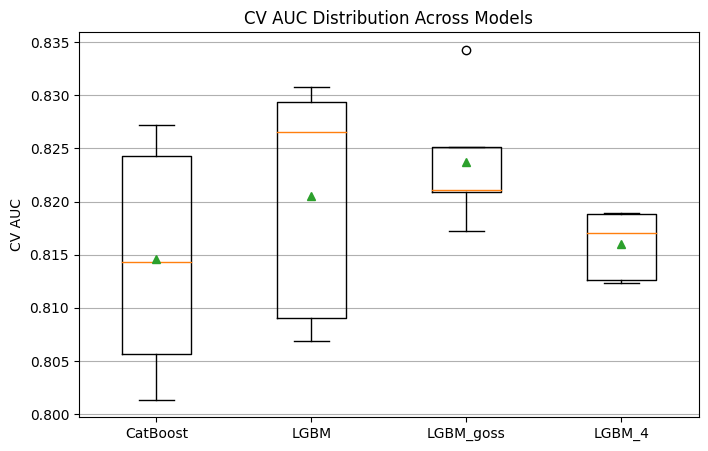

In [27]:
import matplotlib.pyplot as plt
auc_data = [
    cv_scores_cat,
    cv_scores_lgb,
    cv_scores_lgb_3,
    cv_scores_lgb_4
]

labels = ["CatBoost", "LGBM", "LGBM_goss", "LGBM_4"]

plt.figure(figsize=(8, 5))
plt.boxplot(auc_data, labels=labels, showmeans=True)
plt.ylabel("CV AUC")
plt.title("CV AUC Distribution Across Models")
plt.grid(axis="y")
plt.show()

LGBM with GOSS achieves the best balance between average performance and stability but with outlier; <br>
LGBM shows a higher performance ceiling but larger variance across folds; <br>
CatBoost delivers moderate stability with lower overall performance; <br>
LGBM_4 is the most stable model, though its performance upper bound is limited.

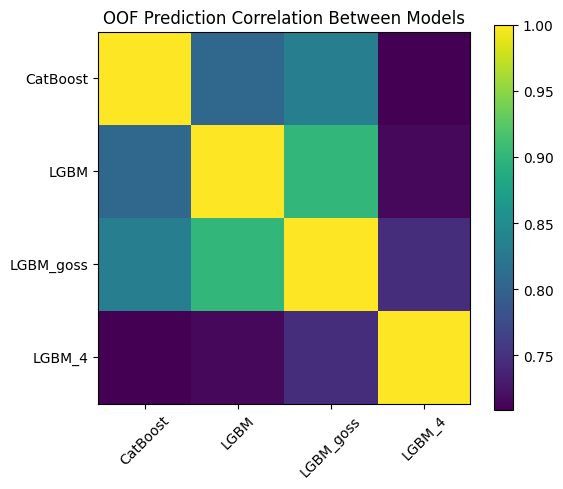

In [28]:
pred_matrix = np.vstack([
    oof_preds["cat"],
    oof_preds["lgb"],
    oof_preds["lgb_3"],
    oof_preds["lgb_4"]
])

corr = np.corrcoef(pred_matrix)

plt.figure(figsize=(6, 5))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(4), labels, rotation=45)
plt.yticks(range(4), labels)
plt.title("OOF Prediction Correlation Between Models")
plt.show()

Based on the OOF prediction correlation analysis, LGBM_4 exhibits the lowest correlation with all other models, indicating that it captures substantially different patterns in the data.

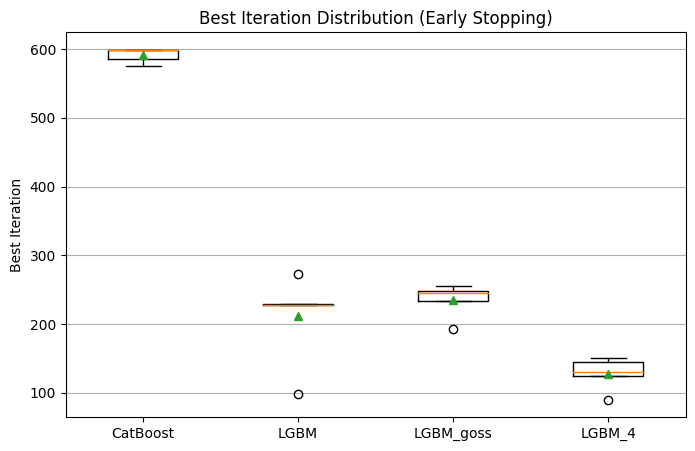

In [29]:
iter_data = [
    best_iters["cat"],
    best_iters["lgb"],
    best_iters["lgb_3"],
    best_iters["lgb_4"]
]

plt.figure(figsize=(8, 5))
plt.boxplot(iter_data, labels=labels, showmeans=True)
plt.ylabel("Best Iteration")
plt.title("Best Iteration Distribution (Early Stopping)")
plt.grid(axis="y")
plt.show()

# test

In [31]:
X_test: pd.DataFrame = df_test.drop(columns=["week_num"]).set_index("case_id")

X_test[cat_cols] = X_test[cat_cols].astype("category")

y_pred: pd.Series = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

df_subm["score"] = y_pred

display(df_subm)

df_subm.to_csv("submission.csv")

del X_test, y_pred, df_subm
gc.collect()

,score
case_id,
57543,0.022875
57549,0.080766
57551,0.011045
57552,0.059564
57569,0.223071
57630,0.022380
57631,0.040059
57632,0.031419
57633,0.092535


10582